In [50]:
# try with xgb, see if it performs any better
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import time

from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

2545964.664 1.37424


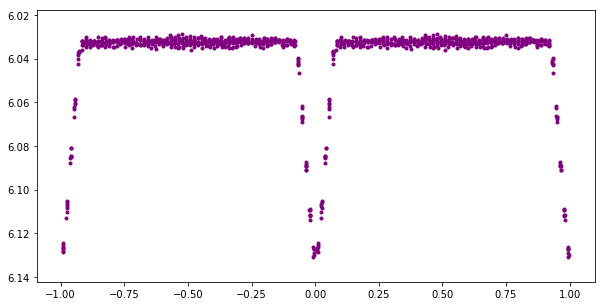

In [51]:
data = pd.read_table("../../Documents/work/TransitClassify/data/1347.ltf", header=None, delimiter=" ")#
data.columns = ["Time", "Flux", "Error?"]

Period=1.37424
Epoch = 2545964.664

print  Epoch, Period
#data["Phase"] = (data["Time"]  - np.ceil((data["Time"]/Period)) * Period)/Period 
data["Phase"] = ((data["Time"] - Epoch) / Period )%1

neg  = (((data["Time"] - Epoch) / Period )%1) -1
fig= plt.figure(figsize=(10,5))
plt.scatter([neg, data["Phase"]], [data["Flux"], data["Flux"]], marker=".", color = "purple")

plt.gca().invert_yaxis()


(960,)
<type 'tuple'>


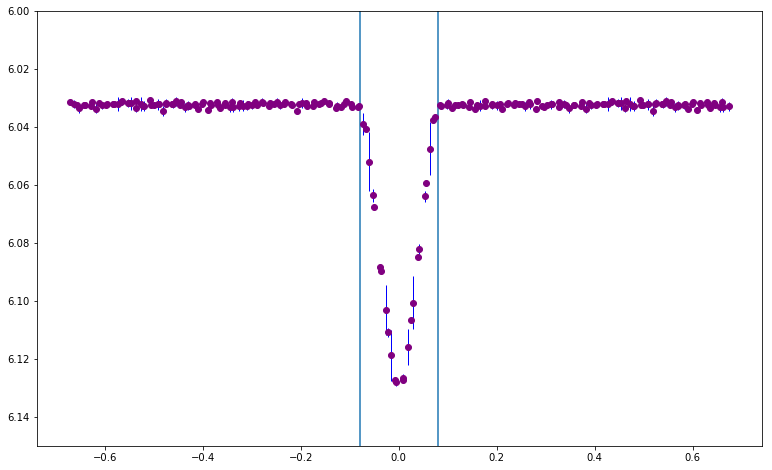

In [52]:
#bin the data
# first combing the ligh curve spanning two periods?, and bin all that
total_time = np.concatenate((neg, data["Phase"]))
total_flux = np.concatenate((data["Flux"], data["Flux"]))
print total_time.shape

#order the points
#create combined tuples
comb = zip(total_time, total_flux) 
#print comb
comb.sort()
total_time, total_flux = zip(*comb)

print type(total_flux)
total_flux = np.asarray(total_flux)

# average over every 10 points?
smoothing_width = 3
smooth_data = []
smooth_time = []
smooth_y_err = []
for i in range(total_flux.shape[0]/smoothing_width):
    #try:
    #print i
    avg_point = np.average( total_flux[i*smoothing_width : i*smoothing_width+smoothing_width])
      
    avg_time = np.average( total_time[i*smoothing_width : i*smoothing_width +smoothing_width])
    #print smoothing_width * i, smoothing_width*i+smoothing_width
    error = np.std( total_flux[i*smoothing_width : i*smoothing_width+smoothing_width])
    #except:
    #print i
    smooth_data.append(avg_point)
    smooth_time.append(avg_time)
    smooth_y_err.append(error)
    
#print len(smooth_data), #len(smooth_time)
#print smooth_data
#print smooth_time

fig = plt.figure(figsize=(13,8))
#plt.scatter(total_time, total_flux, marker=".", color="blue")
truncation = 50
plt.errorbar(smooth_time[truncation:-truncation-1],smooth_data[truncation:-truncation-1],
             yerr =smooth_y_err[truncation:-truncation-1], fmt="o", color = "purple",
            ecolor = "blue", capthick = 2, linewidth = 1)
plt.ylim([6,6.15])
plt.gca().invert_yaxis()
plt.axvline(x=-0.08)
plt.axvline(x=+0.08)
#

In [4]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

In [53]:
#assume for now we know the transit period, transit duration
transit_period = 0.16 * Period #0.16 in phase space
n_trans = 10//Period 
half_trans = 0.08
smooth_time = np.asarray(smooth_time)
smooth_data = np.asarray(smooth_data)
smooth_y_err = np.asarray(smooth_y_err)
n_trans_points = smooth_time[(smooth_time > -half_trans) & 
                             (smooth_time<half_trans)].shape[0]

C [ 0.5488135   0.71518937  0.60276338  0.54488318  0.4236548   0.64589411
  0.43758721]
Red noise 1.97959226939
6.12406666667
6.12406666667 6.03235081312
0.091715853549


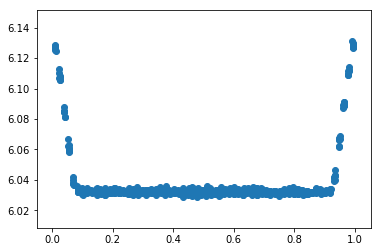

In [54]:
#assume it srandomly distributed between -1 and 1
np.random.seed(0)
C = np.random.uniform(low=0,high=1,size=int(n_trans))

print "C", C
#assume the samme number of n_Trans points for each transits
red_noise = np.sqrt( 1./n_trans_points**2 * np.sum(C * n_trans_points**2))
print "Red noise", red_noise

middle = smooth_data.shape[0]//2
trans_sig = np.mean(smooth_data[(smooth_time > -half_trans/4) & 
                            (smooth_time<half_trans/4)])

print trans_sig
#looks at both side of data on either side of the transit form -0.5 to 0.5
first_avg =  np.mean(smooth_data[(smooth_time>-0.5+half_trans) &
                         (smooth_time<0-half_trans) ])

second_avg= np.mean(smooth_data[(smooth_time<0.5-half_trans) &
                         (smooth_time>0+half_trans) ])
print trans_sig,  (first_avg+second_avg)/2
depth = trans_sig - (first_avg+second_avg)/2 
print depth
plt.scatter(data["Phase"], data["Flux"] )

In [55]:
#creating secondary, tertiary, and positive signal 
#secondary just checks signal at 0.  INCORRECT
second_trans_sig = np.mean(smooth_data[(smooth_time<0.5 +half_trans/2)
                                 &(smooth_time>0.5 -half_trans/2)])
#incorrectly done
mod_sig_sec_dv  = second_trans_sig- (first_avg+second_avg)/2 

In [65]:
# use a moving bin with the current depth and see what the maximum depth is
#go over from 0 to 1 with exceptions of the main transit and secondary transit

# use for loop with trmiied data, it might be easier
#negative half

#work only from -.5 to 05 in phase space for simplicity

smooth_data = smooth_data[(smooth_time>-0.5) & (smooth_time<0.5)]
smooth_time = smooth_time[(smooth_time>-0.5) & (smooth_time<0.5)]


print smooth_data.shape, smooth_time.shape

# I suppose the corect way would be to remove the transit signal. 



trimmed_data = smooth_data[(smooth_time>-0.5+half_trans)
                          & (smooth_time<0-half_trans)]
trimmed_time = smooth_time[(smooth_time>-0.5+half_trans)
                          & (smooth_time<0-half_trans)]
#positve half
trimmed_data2 = smooth_data[(smooth_time<0.5-half_trans)
                          & (smooth_time>0+half_trans)]
trimmed_time2 = smooth_time[(smooth_time<0.5-half_trans)
                          & (smooth_time>0+half_trans)]

print trimmed_data.shape, trimmed_data2.shape

total_trimmed_data = np.concatenate([trimmed_data, trimmed_data2])
total_trimmed_time = np.concatenate([trimmed_time, trimmed_time2])




max_3_depth = 0
max_pos_depth = 0
max_3_Depth_pos = 0

print total_trimmed_data.shape

#find max2

for i in range( total_trimmed_data.shape[0]):
    bin_width = half_trans # check half of the transit width
    try:
        trans_sig = np.mean(total_trimmed_data[(smooth_time>smooth_time[i]) 
                            & (smooth_time< smooth_time[i]+ half_trans)])
        depth_3 =  trans_sig - (first_avg+second_avg)/2
        max_3_depth = np.max([max_3_depth, depth_3])
        if depth_3 == np.max([max_3_depth, depth_3]):
            max_3_Depth_pos=total_trimmed_time[i]
        max_pos_depth=np.min([max_pos_depth, depth_3])
    except Exception as e:
        #print e
        continue
    max_2_depth = max_3_depth
    
print smooth_time[0], smooth_time[-1], max_3_Depth_pos
trimmed_data = total_trimmed_time[(smooth_time<max_3_Depth_pos-half_trans)
                          & (smooth_time>max_3_Depth_pos+half_trans)]
trimmed_time = total_trimmed_time[(smooth_time<max_3_Depth_pos-half_trans)
                          & (smooth_time>max_3_Depth_pos+half_trans)]

print trimmed_data.shape, trimmed_time.shape




#white noise calculated by not accounting primary and secondary transit
print total_trimmed_data.shape
white_noise = np.std(total_trimmed_data) # only removes init
print "white noise", white_noise

#find max3 with smae process by removing away that section in time 
max_3_depth = 0
for i in range( total_trimmed_data.shape[0]):
        bin_width = half_trans # check half of the transit width
        try:
            trans_sig = np.mean(total_trimmed_data[(smooth_time>smooth_time[i]) 
                                & (smooth_time< smooth_time[i]+ half_trans)])
            #first_avg+second_avg/2 signifies teh average flux during out of transit
            depth_3 =  trans_sig - (first_avg+second_avg)/2
            max_3_depth = np.max([max_3_depth, depth_3])
            if depth_3 == np.max([max_3_depth, depth_3]):
                max_3_Depth_pos=total_trimmed_time[i]
            max_pos_depth=np.min([max_pos_depth, depth_3])
        except Exception as e:
            #print e
            continue
    
print max_2_depth, max_3_depth
# the zero signifies that there is no significant tertiary transit
print "Positions", max_3_Depth_pos
mod_sig_sec_dv = max_2_depth
mod_sig_ter_dv = max_3_depth
mod_sig_pos_dv = max_pos_depth
print mod_sig_ter_dv, mod_sig_pos_dv

(160,) (160,)
(56,) (53,)
(109,)
-0.491845189948 0.499338624126 -0.0976879343167
(0,) (0,)
(109,)
white noise 0.000711544285828
0.000262520215635 0.000262520215635
Positions -0.0976879343167
0.000262520215635 -0.000388194070081


/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 109 but corresponding boolean dimension is 160
/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 109 but corresponding boolean dimension is 160
/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 109 but corresponding boolean dimension is 160
/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 109 but corresponding boolean dimension is 160


In [34]:
from scipy.special import erfcinv


#primary signalred noise -signifcance of first event
mod_sig_pri_dv = depth #Should be just depth here # **2 / red_noise**2 #SNR?
mod_fred_dv = red_noise / white_noise # ratio between the two
mod_fa1_dv = np.sqrt(2) * erfcinv(transit_period/(Period* n_trans))
mod_fa2_dv = np.sqrt(2) * erfcinv(transit_period/(Period))

modshiftval1_dv = mod_sig_pri_dv/mod_fred_dv - mod_fa1_dv
modshiftval2_dv = mod_sig_pri_dv - mod_sig_ter_dv-mod_fa2_dv
modshiftval3_dv = mod_sig_pri_dv - mod_sig_pos_dv - mod_fa2_dv
modshiftval4_dv = mod_sig_sec_dv / mod_fred_dv - mod_fa1_dv
modshiftval5_dv = mod_sig_sec_dv - mod_sig_ter_dv - mod_fa2_dv
modshiftval6_dv = mod_sig_sec_dv-mod_sig_pos_dv - mod_fa2_dv

print mod_sig_pri_dv, mod_fred_dv, mod_fa1_dv
print modshiftval1_dv, modshiftval2_dv, modshiftval3_dv
print modshiftval4_dv, modshiftval5_dv, modshiftval6_dv

0.0902253253676 3645.92359888 2.27581402669
-2.27578927978 -1.31484623494 -1.31436456031
-2.27581392167 -1.40468866351 -1.40420698888


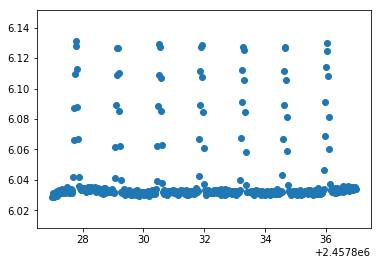

In [35]:
#estimate v(n) - corellation coefficnets between points
#remove points in transit
# need to work in time series
plt.scatter(data["Time"], data["Flux"])
data2 = data.copy()


In [36]:
print mod_sig_pri_dv, transit_period/2
slope = mod_sig_pri_dv/ (transit_period/2)
print slope
#remove this value from anything inside the transit duration
#doing a box least square model

0.0902253253676 0.1099392
0.820683844958


[]
(array([ 33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1]))
(480, 4) (480, 4)


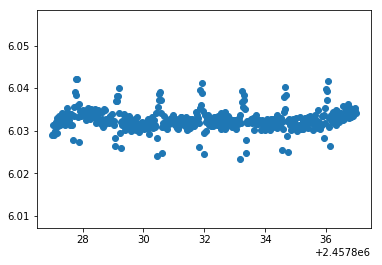

In [42]:
removed_trans = np.empty(shape=[0, 4])
print removed_trans
#print removed_trans.shape

values= data.as_matrix().copy()
#print values
#
#print values
for vals in values:
    vals = vals.reshape([1, 4])
    
    if (vals[0][3] > 0 + half_trans) and (vals[0][3]< 1-half_trans):

        removed_trans = np.concatenate([removed_trans, vals], axis = 0)
    else:
        if vals[0][3] > 0.5:
            vals[0][1]-= (half_trans - np.abs((vals[0][3]-1))) *slope *1.5
      
        else:
            vals[0][1]-= (half_trans - np.abs((vals[0][3] )))* slope *1.5
            #print "phase", vals[0][3], "flux", vals[0][1]
            #print "\n"

       
        removed_trans = np.concatenate([removed_trans, vals], axis = 0)
print np.where((removed_trans==data.values)==False)

print removed_trans.shape, data.shape
plt.scatter(removed_trans[:,0], removed_trans[:,1])
#plt.figure()
#plt.scatter(data["Time"], data["Flux"], marker=".")

[]
(480, 4) (480, 4)
(array([], dtype=int64), array([], dtype=int64))


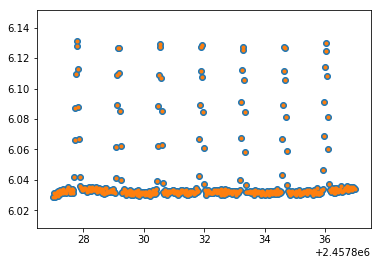

In [43]:
removed_trans = np.empty(shape=[0, 4])
print removed_trans
#print removed_trans.shape

values= data.as_matrix()
values = data.as_matrix().copy()
#print values
#
#print values
for i,vals in enumerate(values):
    vals = vals.reshape([1, 4])
    if (vals[0][3] > 0 + half_trans) and (vals[0][3]< 1-half_trans):
        #print removed_trans.shape, vals.shape
        #print vals.shape, removed_trans.shape
        removed_trans = np.concatenate([removed_trans, vals], axis = 0)
    else:
        removed_trans = np.concatenate([removed_trans, vals], axis = 0)
    #print vals.flatten() ==  data.loc[i].values#[i,:]
    #print "\n"
    
       
print removed_trans.shape, data.shape
print np.where((removed_trans==data.values)==False)
plt.scatter(removed_trans[:,0], removed_trans[:,1])
#plt.figure()
plt.scatter(data["Time"], data["Flux"], marker=".")

In [46]:
# caluclate mean flux over sliding interval equal to transit duration
#keep track of points in each window
#slide over at a pace equal less than transit duration
l = transit_period
mean_flux = []
points = []
removed_trans = pd.DataFrame(removed_trans, columns=data.columns)
for i, vals in enumerate(removed_trans.as_matrix()):
    #print removed_trans["Time"]
    points.append( len(removed_trans["Flux"][(removed_trans["Time"]> vals[0] )
                        & (removed_trans["Time"] < vals[0] + l)]))
    mean_flux.append ( np.mean( removed_trans["Flux"][(removed_trans["Time"]> vals[0] )
                        & (removed_trans["Time"] < vals[0] + l)]))
print mean_flux
    
#points_flux = zip(points, mean_flux)
#point_counts =  np.linspace(0,10,11)
#print points
#places = np.digitize(points_flux, np.linspace(0,20, 21))
#indices =  places[:,0] -1
#indices = indices.astype(int)
#print mean_flux
#values = [[x] for x in point_counts ]
#for i in point_counts:
#    for j in (indices):
        #print i, j
#        if int(i) ==int(j):
            #print i, j 
            #print mean_flux[j]
#            values[int(i)].append(mean_flux[j])
        #break
    #break
            
#print values
#stds = [np.std(x[1:]) for x in values]
#print stds

[6.030859000000001, 6.031052000000001, 6.031418, 6.031662999999999, 6.032003999999999, 6.032276, 6.0322260000000005, 6.03223, 6.032468, 6.032541999999999, 6.0327150000000005, 6.0325109999999995, 6.032641, 6.032850999999999, 6.033044000000001, 6.033025000000001, 6.033034000000001, 6.032990000000001, 6.032933000000002, 6.033059000000001, 6.0331600000000005, 6.033157999999999, 6.033108999999999, 6.033967999999999, 6.037082, 6.042395000000001, 6.050155999999999, 6.0600000000000005, 6.069661000000001, 6.077559, 6.082961, 6.086494, 6.08735, 6.086772, 6.083598, 6.0783380000000005, 6.070760999999999, 6.061024999999999, 6.051619, 6.043818999999999, 6.038456999999999, 6.035259000000001, 6.03445, 6.034169, 6.033947, 6.033811, 6.033977, 6.033908, 6.033836, 6.033727, 6.033574, 6.033616, 6.0336170000000005, 6.033585, 6.0337760000000005, 6.0337760000000005, 6.033703000000001, 6.03375, 6.033946, 6.03383, 6.033744, 6.033615999999999, 6.033687, 6.033645, 6.03348, 6.033404, 6.033383, 6.0331980000000005, 

In [48]:
#each individual point noise would be the binned noise?
smooth_y_err = np.asarray(smooth_y_err)
smooth_y_err.shape, removed_trans.shape

((192,), (480, 4))